In [1]:
import math, random
import numpy as np
from collections import defaultdict
from math import log2
import torch
import matplotlib.pyplot as plt

random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
user_items = dict()
with open("train-1.txt", "r", encoding="utf-8") as g:
    for line in g:
        tokens = line.strip().split()
        # data cleaning: skip lines with only users.
        if len(tokens) < 2:
            continue
        u = tokens[0] 
        # remove dupliacate items for every user.
        items = list(dict.fromkeys(tokens[1:]))
        user_items[u] = set(items)

In [3]:
# ---------- metrics ----------
def average_ndcg(recs, test, k=20):
    vals = list()
    for u, rlist in recs.items():
        gt = test.get(u, set())
        if gt:
            dcg = 0.0
            for i in range(min(k, len(rlist))):
                if rlist[i] in gt:
                    dcg += 1.0 / log2(i+2)
            ideal = min(len(gt), k)
            if ideal == 0: 
                return 0.0
            idcg = sum(1.0 / log2(i+2) for i in range(ideal))
            middle = dcg / idcg
            vals.append(middle)
    return round(float(np.mean(vals)), 5) if vals else 0.0

In [4]:
def cosine(a,b,c):
    return c / math.sqrt(a*b) if a and b else 0.0

def jaccard(a,b,c):
    u = a + b - c
    return c / u if u else 0.0

def pearson(N,a,b,c):
    if a == 0 or b == 0 or a == N or b == N:
        return 0.0
    num = c - (a*b)/N
    den = math.sqrt(a*(1 - a/N) * b*(1 - b/N))
    return num/den if den else 0.0

In [5]:
def build_neighbors(train_ui, k, sim_type):
    N = len(train_ui)
    co = defaultdict(lambda: defaultdict(int))
    deg = defaultdict(int)
    items_all = set()
    for _, items in train_ui.items():
        s = sorted(items)
        items_all.update(s)
        for it in s:
            deg[it] += 1
        for i in range(len(s)):
            a = s[i]
            for j in range(i+1, len(s)):
                b = s[j]
                co[a][b] += 1
    if sim_type == "cosine":
        sim_fn = lambda a,b,c: cosine(a,b,c)
    elif sim_type == "jaccard":
        sim_fn = lambda a,b,c: jaccard(a,b,c)
    else:
        sim_fn = lambda a,b,c: pearson(N,a,b,c)

    nbrs = defaultdict(list)
    for i, row in co.items():
        ai = deg[i]
        for j, c in row.items():
            aj = deg[j]
            s = sim_fn(ai, aj, c)
            if s != 0.0:
                nbrs[i].append((j, s))
                nbrs[j].append((i, s))
    for it in list(nbrs.keys()):
        nbrs[it].sort(key=lambda t: abs(t[1]), reverse=True)
        nbrs[it] = nbrs[it][:k]
    popular = [it for it,_ in sorted(deg.items(), key=lambda kv: (-kv[1], kv[0]))]
    return nbrs, popular

In [6]:
def utility(idx_list, items_u, idx2item, topn, pop_idx):
    ids = list()
    seen = items_u
    for j in idx_list:
        ids.append(idx2item[j])
        if len(ids) == topn:
            break
    if len(ids) < topn:
        have = set(ids) | seen
        for j in pop_idx:
            it = idx2item[j]
            if it not in have:
                ids.append(it)
                if len(ids) == topn:
                    break
    return ids

In [7]:
def recommend_all_gpu(train_user_items, item_ids, item2idx, nbr_idx, nbr_val, popular_items, topn=20):
    idx2item = item_ids

    # Make a popularity backfill list in indices (faster on GPU/CPU mix)
    pop_idx = [item2idx[it] for it in popular_items if it in item2idx]
    all_recs = dict()
    for u, items_u in train_user_items.items():
        # indices first
        I, K = nbr_idx.shape

        if not items_u:
            # cold start: backfill by popularity
            idx_list = (popular_items or [])[:topn]
            all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)

        # Map seen items -> indices
        seen_idx = [item2idx[it] for it in items_u if it in item2idx]
        if not seen_idx:
            idx_list = (popular_items or [])[:topn]
            all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)

        seen_idx_t = torch.tensor(seen_idx, dtype=torch.long, device=device)  # (m,)

        # Gather neighbor rows for all seen items -> (m, K)
        nb_j   = nbr_idx.index_select(0, seen_idx_t)   # neighbor indices (padded with -1)
        nb_sim = nbr_val.index_select(0, seen_idx_t)   # neighbor weights (padded with 0)

        # Flatten contributions
        flat_j   = nb_j.reshape(-1)                    # (m*K,)
        flat_sim = nb_sim.reshape(-1)

        # Drop pads (-1)
        valid = flat_j >= 0
        flat_j   = flat_j[valid]                       # candidate indices
        flat_sim = flat_sim[valid]                     # their contributions

        # Mask out already-seen candidates
        seen_mask = torch.zeros(I, dtype=torch.bool, device=device)
        seen_mask[seen_idx_t] = True
        not_seen = ~seen_mask[flat_j]
        flat_j   = flat_j[not_seen]
        flat_sim = flat_sim[not_seen]

        if flat_j.numel() == 0:
            # no candidates via neighbors -> popularity backfill
            idx_list = [it for it in (popular_items or []) if it not in items_u][:topn]
            all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)

        # Aggregate: sum(sim) and sum(|sim|) per candidate (for normalization)
        scores = torch.zeros(I, dtype=torch.float32, device=device)
        norms  = torch.zeros(I, dtype=torch.float32, device=device)
        scores.scatter_add_(0, flat_j, flat_sim)
        norms.scatter_add_(0, flat_j, flat_sim.abs())

        # Normalize; set seen to -inf so they're never recommended
        denom = torch.where(norms > 0, norms, torch.ones_like(norms))
        final_scores = scores / denom
        final_scores[seen_idx_t] = -float("inf")

        # Top-N
        n_eff = min(topn, I)
        top_scores, top_idx = torch.topk(final_scores, n_eff, largest=True)
        # Filter any -inf (in case user interacted with almost everything)
        mask_finite = torch.isfinite(top_scores) & (top_scores > -1e30)
        top_idx = top_idx[mask_finite].tolist()

        # Backfill with popularity if needed
        if popular_items:
            # convert indices -> ids
            # We need the id list from prepare_torch_neighbors
            # We'll pass it as a closure, or return it from the caller.
            pass

        idx_list = top_idx
        all_recs[u] = utility(idx_list, items_u, idx2item, topn, pop_idx)
    return all_recs

In [8]:
def prepare_torch_neighbors(neighbors, all_items=None, k=None):
    # Build a stable item index (0..I-1)
    if all_items is None:
        item_ids = sorted(neighbors.keys())
    else:
        item_ids = sorted(all_items)
    item2idx = {it: i for i, it in enumerate(item_ids)}
    I = len(item_ids)

    # Determine K from data if not provided
    if k is None:
        k = max((len(v) for v in neighbors.values()), default=0)

    # Allocate (-1 / 0 padding)
    nbr_idx = torch.full((I, k), -1, dtype=torch.long, device=device)
    nbr_val = torch.zeros((I, k), dtype=torch.float32, device=device)

    for it, lst in neighbors.items():
        i = item2idx[it]
        # lst: list[(nbr_item, sim)] — we will keep up to k
        upto = min(k, len(lst))
        if upto == 0: 
            continue
        idxs = [item2idx[nbr] for (nbr, _) in lst[:upto] if nbr in item2idx]
        vals = [float(sim) for (nbr, sim) in lst[:upto] if nbr in item2idx]
        if not idxs:
            continue
        # Put into tensors
        t_idx = torch.tensor(idxs, dtype=torch.long, device=device)
        t_val = torch.tensor(vals, dtype=torch.float32, device=device)
        nbr_idx[i, :len(idxs)] = t_idx
        nbr_val[i, :len(vals)] = t_val

    return item_ids, item2idx, nbr_idx, nbr_val

In [9]:
# ---- Wrapper that matches the CV driver's expected signature ----
def recommend_all_gpu_wrapper(train_user_items_subset, neighbors, popular, topn=20):
    # Pack neighbors to GPU tensors
    item_ids, item2idx, nbr_idx, nbr_val = prepare_torch_neighbors(
        neighbors, all_items=None, k=None)

    # Popularity filtered to indexed items (keep order)
    popular_items = [it for it in popular if it in item2idx]

    # Call your existing GPU recommender
    recs = recommend_all_gpu(
        train_user_items=train_user_items_subset,
        item_ids=item_ids,
        item2idx=item2idx,
        nbr_idx=nbr_idx,
        nbr_val=nbr_val,
        popular_items=popular_items,
        topn=topn
    )
    return recs

In [10]:
import random
import numpy as np

def kfold_users(user_items, n_folds=5, seed=42):
    rng = random.Random(seed)
    users = list(user_items.keys())
    rng.shuffle(users)
    fold_size = int(np.ceil(len(users) / n_folds))
    folds = [users[i*fold_size:(i+1)*fold_size] for i in range(n_folds)]
    return [f for f in folds if f]  # drop any empty tail

In [11]:
def split_user_items_for_cv(items_set, test_frac=0.2, rng=None):
    """Per-user item split: returns (train_items, test_items), ensuring at least 1 test when possible."""
    if rng is None:
        rng = random
    items = list(items_set)
    if len(items) <= 1:
        return set(items), set()
    n_test = max(1, int(round(len(items) * test_frac)))
    test = set(rng.sample(items, n_test))
    train = set(items_set) - test
    if not train:
        # move one back to train to keep both non-empty
        x = next(iter(test))
        test.remove(x)
        train.add(x)
    return train, test

In [12]:
def run_nfold_cv(user_items,
                 n_folds=5,
                 k_values=(5,10,20,30,40,50,75,100),
                 sim_types=("cosine","jaccard","pearson"),
                 test_frac=0.2,
                 topn=20,
                 seed=42,
                 build_neighbors_fn=None,
                 recommend_all_fn=None,
                 average_ndcg_fn=None):
    
    folds = kfold_users(user_items, n_folds=n_folds, seed=seed)
    rng = random.Random(seed)

    per_sim = {sim: np.zeros((len(folds), len(k_values)), dtype=np.float64) for sim in sim_types}

    for f_idx, test_users in enumerate(folds):
        # Train users (all items contribute to training signal)
        train_users = [u for u in user_items if u not in test_users]
        train_ui = {u: set(user_items[u]) for u in train_users if user_items[u]}

        # For users in this fold, split their items into personal train/test
        per_user_train = dict()
        test_ui = dict()
        for u in test_users:
            tr, te = split_user_items_for_cv(user_items[u], test_frac=test_frac, rng=rng)
            if tr:
                per_user_train[u] = tr
            if te:
                test_ui[u] = te

        # Include the train part of test-fold users so their own history can be used
        train_ui.update(per_user_train)

        if not test_ui:
            print(f"[CV] Fold {f_idx+1}: no test ground truth—skipping.")
            continue

        for k_idx, k in enumerate(k_values):
            for sim in sim_types:
                # 1) Build neighbors on current training interactions
                neighbors, popular = build_neighbors_fn(train_ui, k, sim_type=sim)
                # 2) Recommend only for the users we will evaluate (the test fold users), using their train part
                recs = recommend_all_fn(per_user_train, neighbors, popular, topn=topn)
                # 3) Evaluate against held-out items
                score = average_ndcg_fn(recs, test_ui, k=topn)
                per_sim[sim][f_idx, k_idx] = score

        print(f"[CV] Completed fold {f_idx+1}/{len(folds)}")

    # Aggregate across folds
    results = dict()
    for sim in sim_types:
        mat = per_sim[sim]  # (F, K)
        means = [float(np.mean(mat[:, k_idx])) for k_idx in range(len(k_values))]
        results[sim] = {
            "k_values": list(k_values),
            "mean": means,
            "per_fold": mat
        }
    return results

In [13]:
results_04, results_03, results_02, results_01 = None, None, None, None
for i in [0.4, 0.3, 0.2, 0.1]:
    if i == 0.4:
        results_04 = run_nfold_cv(
            user_items=user_items,
            n_folds=5,
            k_values=[5,10,20,30,40,50,75,100],
            sim_types=("cosine","jaccard"),
            test_frac=i,
            topn=20,
            seed=42,
            build_neighbors_fn=build_neighbors,      # or your build_neighbors variant
            recommend_all_fn=recommend_all_gpu_wrapper,          # or recommend_all_gpu for CUDA scoring
            average_ndcg_fn=average_ndcg
        )
    elif i == 0.3:
        results_03 = run_nfold_cv(
            user_items=user_items,
            n_folds=5,
            k_values=[5,10,20,30,40,50,75,100],
            sim_types=("cosine","jaccard"),
            test_frac=i,
            topn=20,
            seed=42,
            build_neighbors_fn=build_neighbors,      # or your build_neighbors variant
            recommend_all_fn=recommend_all_gpu_wrapper,          # or recommend_all_gpu for CUDA scoring
            average_ndcg_fn=average_ndcg
        )
    elif i == 0.2:
        results_02 = run_nfold_cv(
            user_items=user_items,
            n_folds=5,
            k_values=[5,10,20,30,40,50,75,100],
            sim_types=("cosine","jaccard"),
            test_frac=i,
            topn=20,
            seed=42,
            build_neighbors_fn=build_neighbors,      # or your build_neighbors variant
            recommend_all_fn=recommend_all_gpu_wrapper,          # or recommend_all_gpu for CUDA scoring
            average_ndcg_fn=average_ndcg
        )
    else:
        results_01 = run_nfold_cv(
            user_items=user_items,
            n_folds=5,
            k_values=[5,10,20,30,40,50,75,100],
            sim_types=("cosine","jaccard"),
            test_frac=i,
            topn=20,
            seed=42,
            build_neighbors_fn=build_neighbors,      # or your build_neighbors variant
            recommend_all_fn=recommend_all_gpu_wrapper,          # or recommend_all_gpu for CUDA scoring
            average_ndcg_fn=average_ndcg
        )

[CV] Completed fold 1/5
[CV] Completed fold 2/5
[CV] Completed fold 3/5
[CV] Completed fold 4/5
[CV] Completed fold 5/5
[CV] Completed fold 1/5
[CV] Completed fold 2/5
[CV] Completed fold 3/5
[CV] Completed fold 4/5
[CV] Completed fold 5/5
[CV] Completed fold 1/5
[CV] Completed fold 2/5
[CV] Completed fold 3/5
[CV] Completed fold 4/5
[CV] Completed fold 5/5
[CV] Completed fold 1/5
[CV] Completed fold 2/5
[CV] Completed fold 3/5
[CV] Completed fold 4/5
[CV] Completed fold 5/5


In [14]:
print("Cosine  mean NDCG@20 per k test_frac 0.4:", [float(f"{v:.5f}") for v in results_04["cosine"]["mean"]])
print("Jaccard mean NDCG@20 per k test_frac 0.4:", [float(f"{v:.5f}") for v in results_04["jaccard"]["mean"]])
#print("Pearson mean NDCG@20 per k test_frac 0.4:", [float(f"{v:.5f}") for v in results_04["pearson"]["mean"]])

print("Cosine  mean NDCG@20 per k test_frac 0.3:", [float(f"{v:.5f}") for v in results_03["cosine"]["mean"]])
print("Jaccard mean NDCG@20 per k test_frac 0.3:", [float(f"{v:.5f}") for v in results_03["jaccard"]["mean"]])
#print("Pearson mean NDCG@20 per k test_frac 0.3:", [float(f"{v:.5f}") for v in results_03["pearson"]["mean"]])

print("Cosine  mean NDCG@20 per k test_frac 0.2:", [float(f"{v:.5f}") for v in results_02["cosine"]["mean"]])
print("Jaccard mean NDCG@20 per k test_frac 0.2:", [float(f"{v:.5f}") for v in results_02["jaccard"]["mean"]])
#print("Pearson mean NDCG@20 per k test_frac 0.2:", [float(f"{v:.5f}") for v in results_02["pearson"]["mean"]])

print("Cosine  mean NDCG@20 per k test_frac 0.1:", [float(f"{v:.5f}") for v in results_01["cosine"]["mean"]])
print("Jaccard mean NDCG@20 per k test_frac 0.1:", [float(f"{v:.5f}") for v in results_01["jaccard"]["mean"]])
#print("Pearson mean NDCG@20 per k test_frac 0.1:", [float(f"{v:.5f}") for v in results_01["pearson"]["mean"]])

Cosine  mean NDCG@20 per k test_frac 0.4: [0.03008, 0.027, 0.02353, 0.02304, 0.02217, 0.02199, 0.02209, 0.02226]
Jaccard mean NDCG@20 per k test_frac 0.4: [0.03222, 0.0288, 0.02494, 0.02362, 0.02319, 0.02303, 0.02261, 0.02276]
Cosine  mean NDCG@20 per k test_frac 0.3: [0.02672, 0.02357, 0.02131, 0.01982, 0.02008, 0.01994, 0.02001, 0.02033]
Jaccard mean NDCG@20 per k test_frac 0.3: [0.02868, 0.02537, 0.02152, 0.02104, 0.0205, 0.02078, 0.02059, 0.02108]
Cosine  mean NDCG@20 per k test_frac 0.2: [0.02218, 0.0199, 0.01753, 0.01714, 0.01718, 0.01711, 0.01745, 0.01741]
Jaccard mean NDCG@20 per k test_frac 0.2: [0.02376, 0.02073, 0.01799, 0.01751, 0.0177, 0.01777, 0.01731, 0.01694]
Cosine  mean NDCG@20 per k test_frac 0.1: [0.01775, 0.01573, 0.01381, 0.01333, 0.01382, 0.01354, 0.01428, 0.01427]
Jaccard mean NDCG@20 per k test_frac 0.1: [0.01905, 0.01649, 0.014, 0.01378, 0.01404, 0.01369, 0.01418, 0.01424]


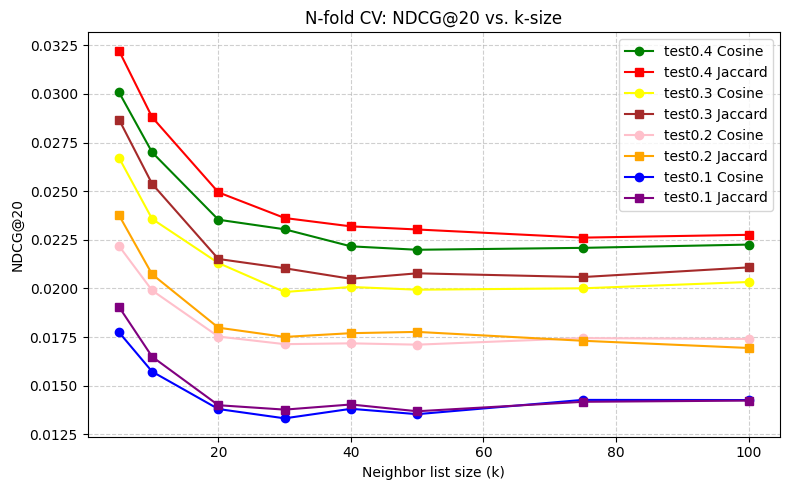

In [15]:
# ---------- plot ----------
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(results_04["cosine"]["k_values"],  results_04["cosine"]["mean"],  marker="o", color="green", label="test0.4 Cosine")
ax.plot(results_04["jaccard"]["k_values"], results_04["jaccard"]["mean"], marker="s", color="red", label="test0.4 Jaccard")
#ax.plot(results["pearson"]["k_values"], results["pearson"]["mean"], marker="^", label="Pearson")
ax.plot(results_03["cosine"]["k_values"],  results_03["cosine"]["mean"],  marker="o", color="yellow", label="test0.3 Cosine")
ax.plot(results_03["jaccard"]["k_values"], results_03["jaccard"]["mean"], marker="s", color="brown", label="test0.3 Jaccard")
ax.plot(results_02["cosine"]["k_values"],  results_02["cosine"]["mean"],  marker="o", color="pink", label="test0.2 Cosine")
ax.plot(results_02["jaccard"]["k_values"], results_02["jaccard"]["mean"], marker="s", color="orange", label="test0.2 Jaccard")
ax.plot(results_01["cosine"]["k_values"],  results_01["cosine"]["mean"],  marker="o", color="blue", label="test0.1 Cosine")
ax.plot(results_01["jaccard"]["k_values"], results_01["jaccard"]["mean"], marker="s", color="purple", label="test0.1 Jaccard")
ax.set_xlabel("Neighbor list size (k)")
ax.set_ylabel("NDCG@20")
ax.set_title("N-fold CV: NDCG@20 vs. k-size")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()